In [128]:
from functions import *

# import functions
# from importlib import reload
# reload(functions)

Short display of the data.

In [112]:
FULL_DF = pd.read_csv("philosophy_data.csv", converters={"tokenized_sentence": pd.eval})

In [113]:
#Filter dataframe to training, test, fulldataset
train_data = 0.8
indexes = [i for i in list(FULL_DF.sample(frac=train_data).index)]
DF_TRAIN = FULL_DF.iloc[indexes]
DF_TRAIN.reset_index(drop = True, inplace = True)
DF_TEST = FULL_DF.iloc[~FULL_DF.index.isin(indexes)]
DF_TEST.reset_index(drop = True, inplace = True)

#Comment these to be able to train.
DF_TEST = FULL_DF
DF_TRAIN = FULL_DF

len(FULL_DF.index), len(DF_TEST.index), len(DF_TRAIN.index)

(308807, 308807, 308807)

In [114]:
DF_TRAIN.sample(5)

,school,author,title,tokenized_sentence,num_of_chars,num_of_words,string_sentence
97186,phenomenology,Edmund Husserl,the crisis of european sciences and transcende...,"[real, entities, world]",19,3,real entities world
19528,rationalism,Nicolas Malebranche,malebranche: the search after truth,"[elucidations, search, truth, likewise, figure...",292,32,elucidations search truth likewise figure inte...
35176,analytic,Ludwig Wittgenstein,philosophical investigations,"[certainly, propositions, human, beings, belie...",65,9,certainly propositions human beings believe tw...
140805,continental,Michel Foucault,history of madness,"[new, entities, important, far, clearly, saint...",54,8,new entities important far clearly saint luke ...
111280,phenomenology,Martin Heidegger,off the beaten track,"[consciousness, conscious, means, come, presen...",82,10,consciousness conscious means come presence br...


Extract the tokenized_sentence DF["tokenized_sentence"] sentences and append them into a python list.

Load w2v model, Skip-gram, CBOW

In [115]:
skipgram_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,       # Dimensionality of word embeddings
            sg = 1,                # SKIPGRAM
            window=5,              # Word window for context evaluation
            epochs=10)             # Number of epochs training over corpus

cbow_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,
            sg = 0,                # CBOW
            window=5,
            epochs=10)

len(skipgram_w2v.wv), len(cbow_w2v.wv)

(26655, 26655)

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.
Can also be used with pretrained models.

In [116]:
DF_TEST, skipgram_sentences = vectorize_sentences(skipgram_w2v.wv, DF_TEST)
DF_TEST, cbow_sentences = vectorize_sentences(cbow_w2v.wv, DF_TEST)

#Should be equal
len(DF_TEST["tokenized_sentence"]), len(skipgram_sentences), len(cbow_sentences)

(307729, 307729, 307729)

Fetch the number of unique School of Thoughts.

In [117]:
unique_schools = DF_TEST["school"].unique().tolist()
print(unique_schools)
num_clusters = len(unique_schools)

['rationalism', 'analytic', 'empiricism', 'phenomenology', 'capitalism', 'continental', 'plato', 'aristotle', 'german_idealism', 'marxism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

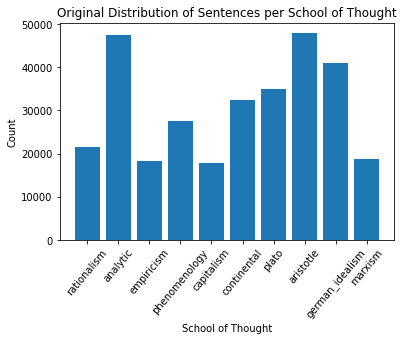

In [118]:
total_dict = dict.fromkeys(unique_schools, 0)
for school in DF_TEST["school"]:
    total_dict[school] += 1

plt.bar(range(len(total_dict)), total_dict.values(), align='center')
plt.xticks(range(len(total_dict)), total_dict.keys())
plt.xticks(rotation=50)
plt.xlabel("School of Thought")
plt.ylabel("Count")
plt.title("Original Distribution of Sentences per School of Thought")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [119]:
start = time.time()

#Skip-gram and cbow.
skipgram_w2v_kmeans, skipgram_w2v_labels, skipgram_w2v_centroids = apply_kmeans(num_clusters, skipgram_sentences)
cbow_w2v_kmeans, cbow_w2v_labels, cbow_w2v_centroids = apply_kmeans(num_clusters, cbow_sentences)

end = time.time()
print(end - start)

216.2641875743866


Apply scatter plot on kmeans results using TSNE.
Scatter plot using TSNE, PCA and UMAP

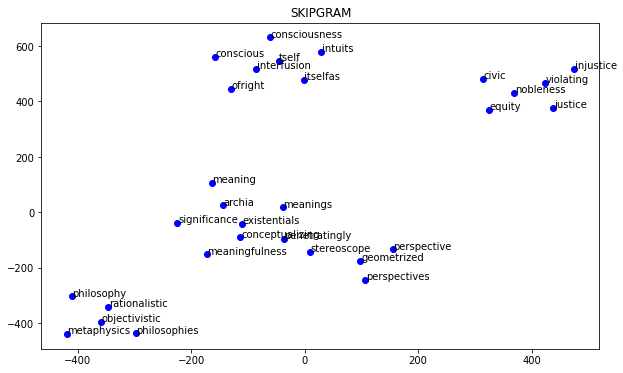

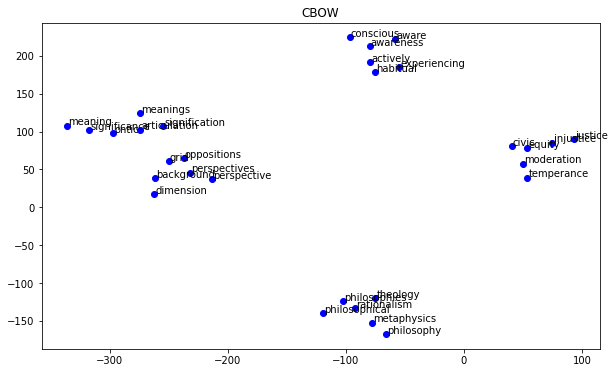

In [120]:
# scatter_plot(type='pca', labels=skipgram_w2v_labels, values=skipgram_sentences)
# scatter_plot(type='pca', labels=cbow_w2v_labels, values=cbow_sentences)

words = ['meaning', 'philosophy', 'justice', 'conscious', 'perspective']
plot_similar_words(skipgram_w2v.wv, words, title="SKIPGRAM",top_words=5)
plot_similar_words(cbow_w2v.wv, words,title="CBOW", top_words=5)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

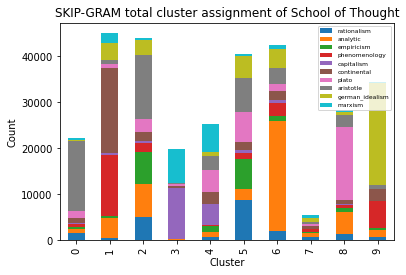

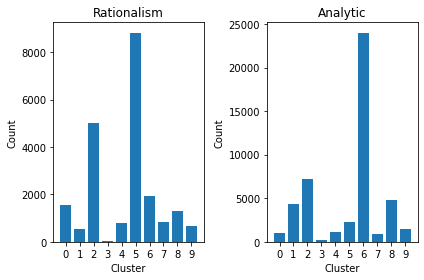

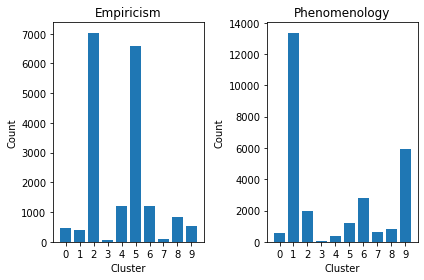

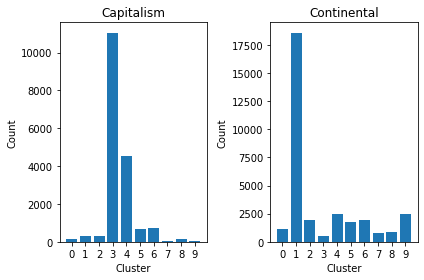

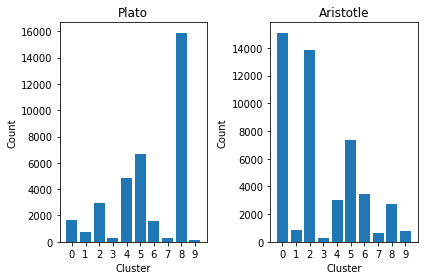

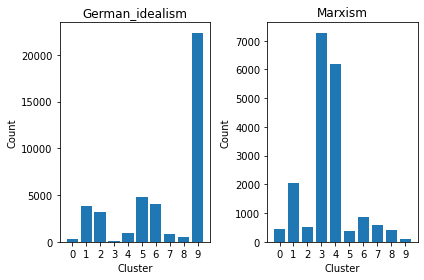

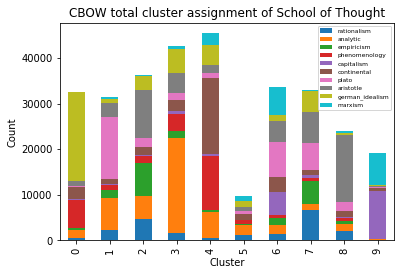

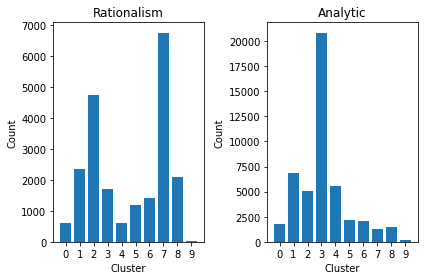

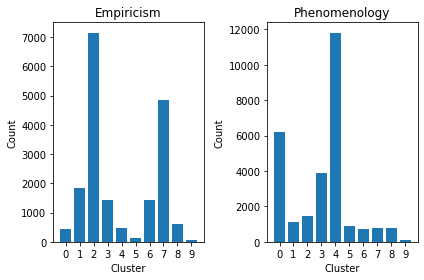

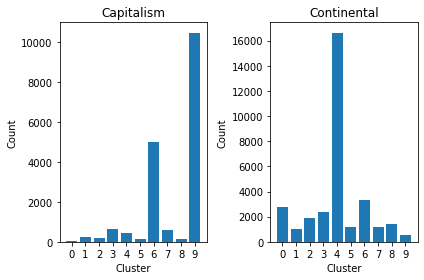

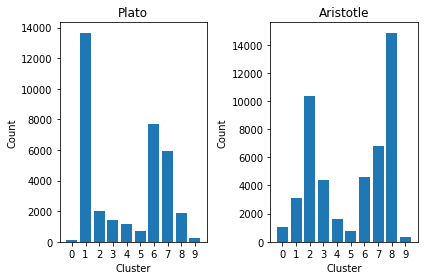

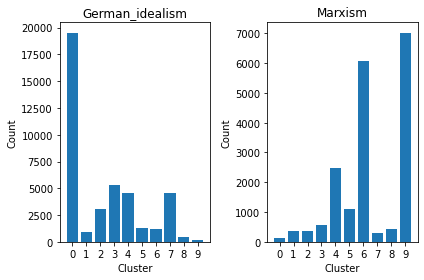

In [121]:
#How many times cluster n was assigned to specific SOT
cluster_n_assigned(DF=DF_TEST, labels=skipgram_w2v_labels, schools=unique_schools, name='skip-gram')
cluster_n_assigned(DF=DF_TEST, labels=cbow_w2v_labels, schools=unique_schools, name='cbow')

Make a list and convert all "plato" to 0 and "aristotle" to 1, etc.
This can then be applied with the predicted labels with v_measure.

In [122]:
original_labels = [unique_schools.index(school) for school in DF_TEST["school"]]

Apply v-measure.

In [123]:
#w2v
skipgram_v_measure = v_measure_score(original_labels, skipgram_w2v_labels)
cbow_v_measure = v_measure_score(original_labels, cbow_w2v_labels)

skipgram_v_measure, cbow_v_measure

(0.278762158370683, 0.2356578387180599)

Calculate the best v_measure.
Apply different values for window/vector_size/iterations.
vector_size: 50 -> 100 -> 300
window: 2 -> 3 -> 5 -> 7

Saving the V-max in the dataframes.

In [129]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 50
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 100.654261136055
Average Time per Iteration: 78.567063498497
Average Time per Iteration: 116.75602822303772
Average Time per Iteration: 98.69286043643952
Average Time per Iteration: 146.2825604915619
Average Time per Iteration: 85.40814485549927
Average Time per Iteration: 158.88625922203065
Average Time per Iteration: 76.04396569728851


In [130]:
v_measure_dict_50 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 50 Vec Size
v_measure_plot_dict_50 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_50 = pd.DataFrame.from_dict(v_measure_plot_dict_50, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_50.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.255738,0.225092
Window_3,0.265040,0.228542
Window_5,0.272842,0.234141
Window_7,0.276469,0.235984


In [131]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 100
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 116.1892431974411
Average Time per Iteration: 106.11282489299774
Average Time per Iteration: 165.9156130552292
Average Time per Iteration: 115.42565574645997
Average Time per Iteration: 188.21064333915712
Average Time per Iteration: 167.68411819934846
Average Time per Iteration: 295.5310094594955
Average Time per Iteration: 115.71999197006225


In [132]:
v_measure_dict_100 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 100 Vec Size
v_measure_plot_dict_100 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_100 = pd.DataFrame.from_dict(v_measure_plot_dict_100, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_100.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.261376,0.229955
Window_3,0.269846,0.232006
Window_5,0.276394,0.236146
Window_7,0.279666,0.238180


In [133]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 300
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 345.82296068668364
Average Time per Iteration: 397.05436182022095
Average Time per Iteration: 393.77456402778625
Average Time per Iteration: 270.5711382627487
Average Time per Iteration: 398.31087045669557
Average Time per Iteration: 291.6644560098648
Average Time per Iteration: 446.68979160785676
Average Time per Iteration: 304.8281106710434


In [134]:
v_measure_dict_300 = {"skipgram_2": v_measure_list_skipgram_2,
                   "skipgram_3": v_measure_list_skipgram_3,
                   "skipgram_5": v_measure_list_skipgram_5,
                   "skipgram_7": v_measure_list_skipgram_7,
                   "cbow_2": v_measure_list_cbow_2,
                   "cbow_3": v_measure_list_cbow_3,
                   "cbow_5": v_measure_list_cbow_5,
                   "cbow_7": v_measure_list_cbow_7}

# 300 Vec Size
v_measure_plot_dict_300 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_300 = pd.DataFrame.from_dict(v_measure_plot_dict_300, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_300.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.265604,0.229927
Window_3,0.273504,0.232596
Window_5,0.281063,0.236675
Window_7,0.283616,0.238322
